Import the necessary libraries and functions:

In [1]:
from PIL import Image
from io import BytesIO
from matplotlib.pyplot import imshow
from math import atan2, exp, pi, sqrt
import numpy as np
import requests

Load an example image from the web and display it:

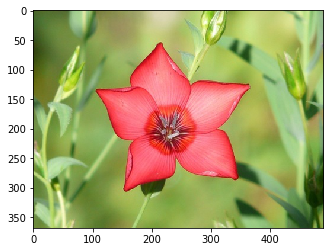

In [2]:
url = 'http://images.all-free-download.com/images/graphicthumb/light_red_red_lein_flower_220297.jpg'
# url = 'https://s-media-cache-ak0.pinimg.com/736x/42/14/1f/42141fb11f2c395fefd96f371b14bee5.jpg'

response = requests.get(url)
image = Image.open(BytesIO(response.content))

%matplotlib inline
imshow(np.asarray(image))

Manually convert it to grayscale, instead of calling `image.convert(mode='L')`:

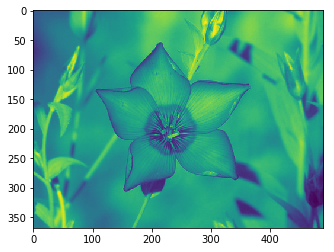

In [3]:
grayscale = Image.new(mode='L', size=(image.width, image.height))

for y in range(image.height):
    for x in range(image.width):
        red, green, blue = image.getpixel((x, y))
        intensity = int(red * 0.299 + green * 0.587 + blue * 0.114)
        grayscale.putpixel((x, y), intensity)

imshow(np.asarray(grayscale))

The **convolution** function in two dimensions is defined on page 953 as follows:

\begin{equation*}
h(x,y) = (f*g)(x,y) = \sum_{u=-\infty}^{+\infty} \sum_{v=-\infty}^{+\infty} f(u,v) g(x - u,y - v)
\end{equation*}

Given a pixel location $(x, y)$, it returns the sums of all the pixels in a rectangular area around that position. The rectangular area is defined by $u$ and $v$. In the formula above these run from $-\infty$ to $+\infty$, but in practice we limit these to much smaller values.

The `convolve` function below defines and returns the $h(x,y)$ above:

In [4]:
def convolve(f, g, u_radius, v_radius):
    def h(x, y):
        sum = 0
        for u in range(-u_radius, u_radius + 1):
            for v in range(-v_radius, v_radius + 1):
               sum = sum + f(u, v) * g(x - u, y - v)
        return sum
    return h

We will shortly implement Gaussian blurring by convolving with the Gaussian function. This function is defined as:

\begin{equation*}
N_{\sigma}(x,y) = \frac{1}{2\pi\sigma^2} e^{-(x^2+y^2)/2\sigma^2}
\end{equation*}

The `gaussian` function below implements this:

In [5]:
def gaussian(x, y, sigma):
    return exp(-(x**2 + y**2) / (2 * sigma**2)) / (2 * pi * sigma**2)

Now we will combine these two functions to define our own specific $h(x,y) = (f*g)(x,y)$ or simply $h = f*g$.

Note that, since the $f(u,v)$ operates only on $u$ and $v$, which are the relative distances to $(x,y)$, we can plug in our `gaussian` function above. That function has no knowledge of $(x,y)$. We'll fix the $\sigma$ parameter to a small value such as two:

```python
lambda x, y: gaussian(x, y, 2)
```

For the $g(x - u, y - v)$ we plug in a simple function that just returns the intensity of the grayscale pixel at that location:

```python
lambda x, y: grayscale.getpixel((x, y))
```

For the radiuses of $u$ and $v$ we've picked the value $3$, so both run from $-3$ to $+3$, for a rectangular neighborhood of $7 * 7 = 49$ pixels.

The combined result looks like this:

In [6]:
h = convolve(
    f=lambda x, y: gaussian(x, y, 2),
    g=lambda x, y: grayscale.getpixel((x, y)),
    u_radius=3,
    v_radius=3)

Now let's apply the $h(x,y)$ we just defined to the grayscale image. We should end up with another grayscale image, but slightly blurred this time:

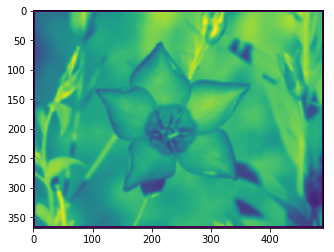

In [7]:
blurred = Image.new(mode='L', size=(grayscale.width, grayscale.height))

for y in range(3, grayscale.height - 3):
    for x in range(3, grayscale.width - 3):
        blurred.putpixel((x, y), int(h(x, y)))

imshow(np.asarray(blurred))

After smoothing an image to reduce or remove any unwanted noise, we can look for edges:

1. We smooth by applying a Gaussian convolution, as demonstrated above.
2. We find edges by looking at the **derivatives** of the resulting image intensity.

The deriviate tells us how quickly the image intensity changes, from dark to light or from light to dark. If the image does not change at all at $(x,y)$, its deriviate there will be zero, and if it changes only slightly, it will still be close to zero.

Edges are defined as significant changes in image intensity, and thus should result in a relatively large positive or negative derivative.

A trick is that we can perform both steps in one, as the following are equal:

\begin{equation*}
(f * g)' = f * g'
\end{equation*}

Let's look at edge in both directions. We'll need to define the derivatives of the Gaussian function in both $x$ and $y$.

For the single dimension $x$, the Gaussian and its derivative are defined as:

\begin{equation*}
N_{\sigma}(x) = \frac{1}{\sqrt{2\pi}\sigma} e^{-x^2/2\sigma^2} \\
N_{\sigma}^{'}(x) = \frac{x}{\sqrt{2\pi}\sigma^3} e^{-x^2/2\sigma^2}
\end{equation*}

And of course similar for $y$. Let's plug these in, first the derivative Gaussian:

In [8]:
def gaussian_derivative(x, sigma):
    return x * exp(-x**2 / (2 * sigma**2)) / (sqrt(2 * pi) * sigma**3)

Now we'll use this one to find edges in both directions independently. First up are vertical edges. Note that we use the Gaussian derivative with respect to **x** here, since a vertical edge can be considered a line that runs up and down, and we detect it by means of an intensity change moving horizontally:

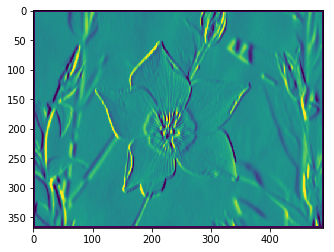

In [9]:
h = convolve(
    f=lambda x, y: gaussian_derivative(x, 1),
    g=lambda x, y: grayscale.getpixel((x, y)),
    u_radius=3,
    v_radius=3)

edges_vertical = Image.new(mode='L', size=(grayscale.width, grayscale.height))

for y in range(3, grayscale.height - 3):
    for x in range(3, grayscale.width - 3):
        edges_vertical.putpixel((x, y), 128 + int(h(x, y)))

imshow(np.asarray(edges_vertical))

And horizontal edges:

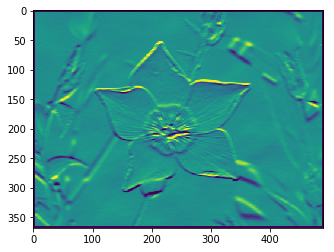

In [10]:
h = convolve(
    f=lambda x, y: gaussian_derivative(y, 1),
    g=lambda x, y: grayscale.getpixel((x, y)),
    u_radius=3,
    v_radius=3)

edges_horizontal = Image.new(mode='L', size=(grayscale.width, grayscale.height))

for y in range(3, grayscale.height - 3):
    for x in range(3, grayscale.width - 3):
        edges_horizontal.putpixel((x, y), 128 + int(h(x, y)))

imshow(np.asarray(edges_horizontal))

We can also apply the **Sobel** operator to find edges. It is defined as a convolution with, for vertical edges:

\begin{equation*}
\begin{bmatrix}
  -1 & 0 & +1 \\
  -2 & 0 & +2 \\
  -1 & 0 & +1
\end{bmatrix}
\end{equation*}

And for horizontal edges:
\begin{equation*}
\begin{bmatrix}
  +1 & +2 & +1 \\
   0 &  0 &  0 \\
  -1 & -2 & -1
\end{bmatrix}
\end{equation*}

Let's implement these. First, the matrices:

In [11]:
vertical_matrix = [
    [-1, 0, +1],
    [-2, 0, +2],
    [-1, 0, +1]
]

horizontal_matrix = [
    [+1, +2, +1],
    [ 0,  0,  0],
    [-1, -2, -1]
]

Then we'll create the vertical edges:

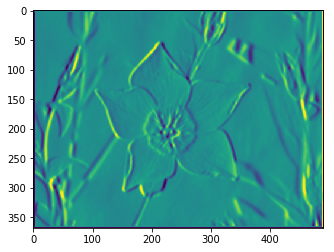

In [12]:
h = convolve(
    f=lambda u, v: vertical_matrix[1 + v][1 + u],
    g=lambda x, y: blurred.getpixel((x, y)),
    u_radius=1,
    v_radius=1)

edges_vertical = Image.new(mode='L', size=(blurred.width, blurred.height))

for y in range(1, blurred.height - 1):
    for x in range(1, blurred.width - 1):
        edges_vertical.putpixel((x, y), 128 + h(x, y))

imshow(np.asarray(edges_vertical))

Followed by the horizontal edges:

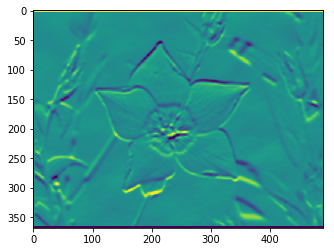

In [13]:
h = convolve(
    f=lambda u, v: horizontal_matrix[1 + v][1 + u],
    g=lambda x, y: blurred.getpixel((x, y)),
    u_radius=1,
    v_radius=1)

edges_horizontal = Image.new(mode='L', size=(blurred.width, blurred.height))

for y in range(1, blurred.height - 1):
    for x in range(1, blurred.width - 1):
        edges_horizontal.putpixel((x, y), 128 + int(h(x, y)))

imshow(np.asarray(edges_horizontal))

And to calculate the **orientation** of the edge, i.e. its angle $\theta$, we can use the `atan2` function and pass it the vertical and horizontal gradients, respectively. It will return the angle $\theta$ that the edge makes, where:

\begin{equation*}
-\pi \le \theta \le +\pi
\end{equation*}

The angle $\theta$ is measured with respect to the positive x-axis.

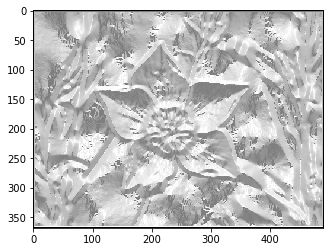

In [44]:
h1 = convolve(
    f=lambda u, v: vertical_matrix[1 + v][1 + u],
    g=lambda x, y: blurred.getpixel((x, y)),
    u_radius=1,
    v_radius=1)

h2 = convolve(
    f=lambda u, v: horizontal_matrix[1 + v][1 + u],
    g=lambda x, y: blurred.getpixel((x, y)),
    u_radius=1,
    v_radius=1)

orientation = Image.new(mode='RGB', size=(blurred.width, blurred.height))

for y in range(1, blurred.height - 1):
    for x in range(1, blurred.width - 1):
        vertical_gradient   = h1(x, y)
        horizontal_gradient = h2(x, y)

        theta     = atan2(vertical_gradient, horizontal_gradient)  # range [-pi, +pi]
        intensity = int((abs(theta) + pi) * 255 / (2 * pi))        # range [0, 255]
        
        orientation.putpixel((x, y), (intensity, intensity, intensity))

imshow(np.asarray(orientation))